## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [136]:
from ipywidgets import interact, interactive, fixed


In [137]:
import numpy as np
import os.path
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

DISTORT_P = 'distort.p'

is_show_calibration_result = False

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

if not os.path.isfile(DISTORT_P):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    data = {'mtx': mtx,
            'dist': dist}

    with open(DISTORT_P, 'wb') as output:
        pickle.dump(data, output)
else:
    dist_pickle = pickle.load(open(DISTORT_P, "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

if is_show_calibration_result:
    for fname in images:
        img = mpimg.imread(fname)

        dst = cv2.undistort(img, mtx, dist, None, mtx)

        plt.figure(figsize=(16, 12))
        plt.subplot(121)
        plt.imshow(img)
        plt.title('Before')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(dst)
        plt.title('After')
        plt.axis('off')
        plt.show()

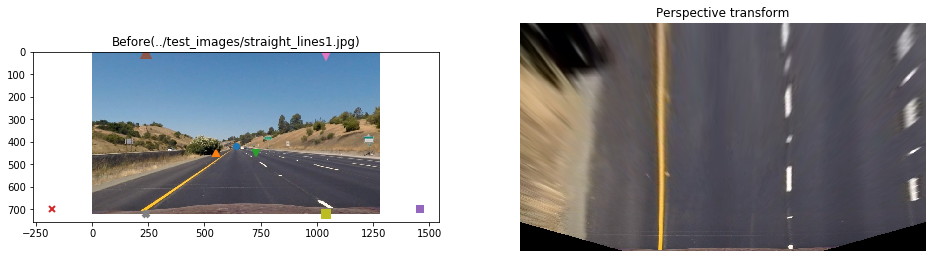

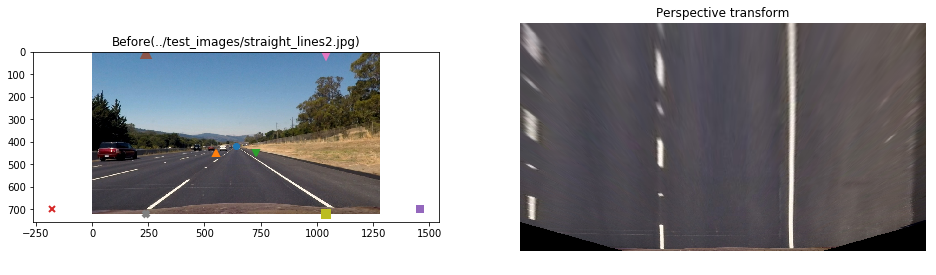

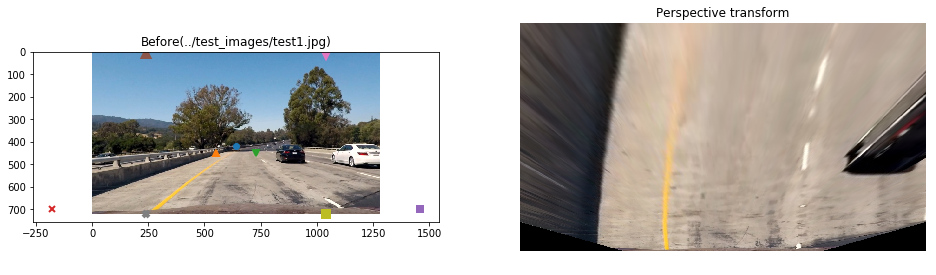

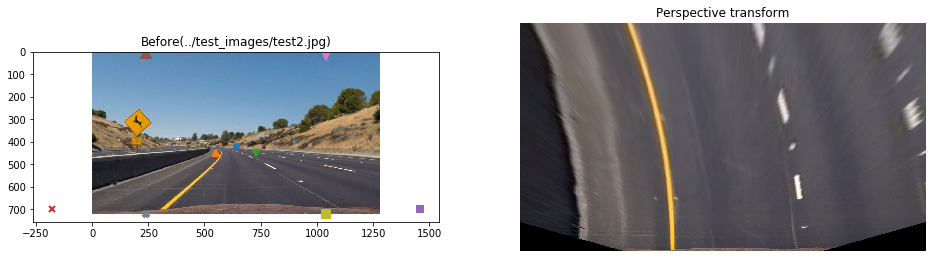

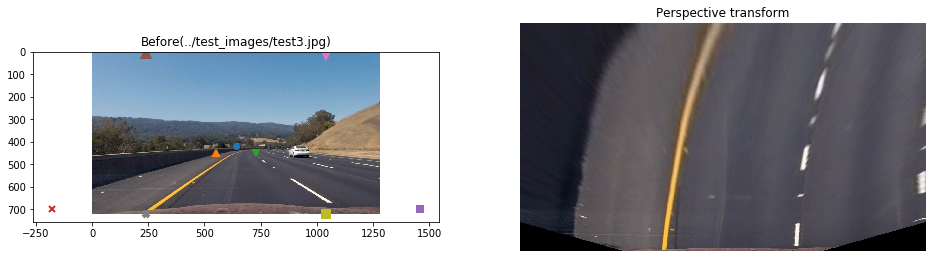

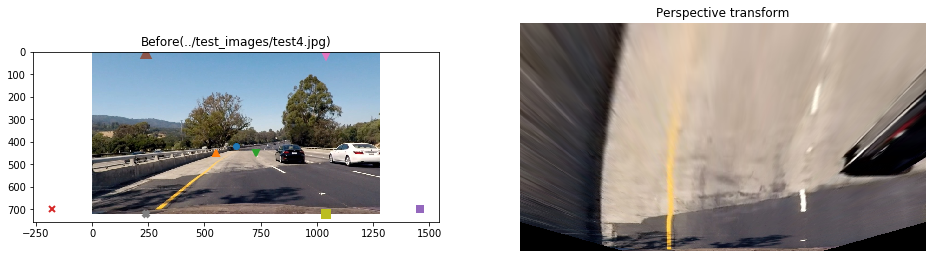

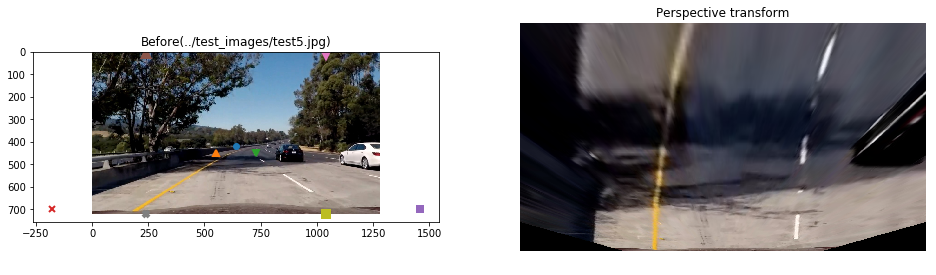

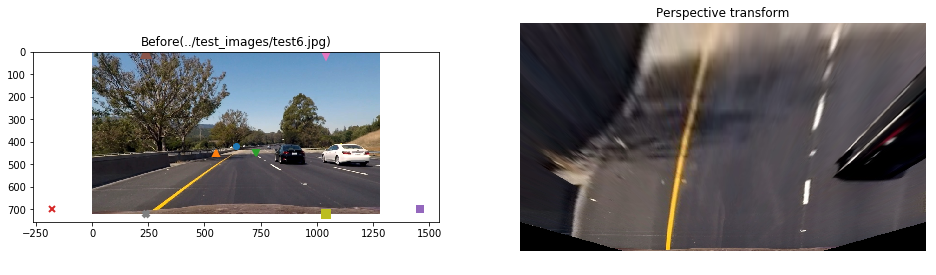

In [285]:
mid = 1280/2
t1, b1 = 450, 700
t_tw = 90
t_bw = 820
t2, b2 = 10, 720
tw = 400

src = np.float32([[mid-t_tw, t1], [mid+t_tw, t1], [mid-t_bw, b1], [mid+t_bw, b1]])
dst = np.float32([[mid-tw, t2], [mid+tw, t2], [mid-tw, b2], [mid+tw, b2]])

M = cv2.getPerspectiveTransform(src, dst)

images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    plt.figure(figsize=(16, 12))
    plt.subplot(121)
    plt.imshow(undist)
    
    plt.plot(640, 420, 'o', mew=1)
    
    plt.plot(mid-t_tw, t1, '^', mew=2)
    plt.plot(mid+t_tw, t1, 'v', mew=2)
    plt.plot(mid-t_bw, b1, 'x', mew=2)
    plt.plot(mid+t_bw, b1, 's', mew=2)

    plt.plot(mid-tw, t2, '^', mew=4)
    plt.plot(mid+tw, t2, 'v', mew=4)
    plt.plot(mid-tw, b2, 'x', mew=4)
    plt.plot(mid+tw, b2, 's', mew=4)
    
    plt.title('Before('+fname+')')
    plt.subplot(122)
    plt.imshow(warped)
    plt.title('Perspective transform')
    plt.axis('off')
    plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image

1. Color space (Gray, HLS, YUV, HSV)
2. Sobel
3. Magnitude of the Gradient


In [277]:
img = cv2.imread('../test_images/test5.jpg')

In [278]:
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [279]:
channel = hls[:, :, 2]

In [280]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(channel, orient='x', sobel_kernel=3, abs_sobel_thresh_min=0, abs_sobel_thresh_max=255):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 0, 1))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_sobel_thresh_min) & (scaled_sobel <= abs_sobel_thresh_max)] = 1

    # Return the result
    return binary_output

In [281]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(channel, sobel_kernel=3, mag_thresh_min=0, mag_thresh_max=255):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh_min) & (gradmag <= mag_thresh_max)] = 1

    # Return the binary image
    return binary_output

In [282]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(channel, sobel_kernel=3, dir_thresh_min=0, dir_thresh_max=np.pi/2):
    # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh_min) & (absgraddir <= dir_thresh_max)] = 1

    # Return the binary image
    return binary_output

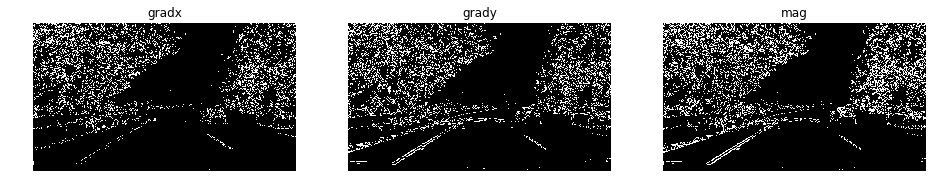

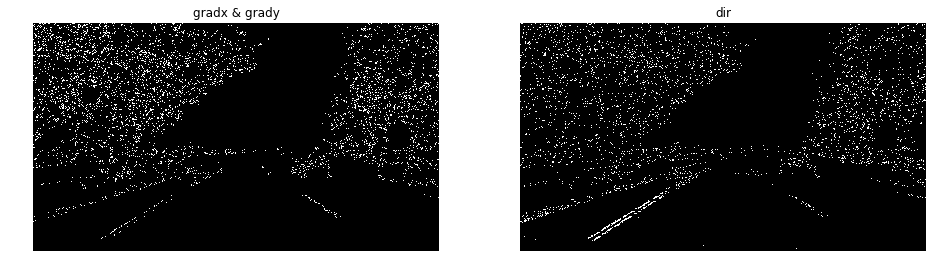

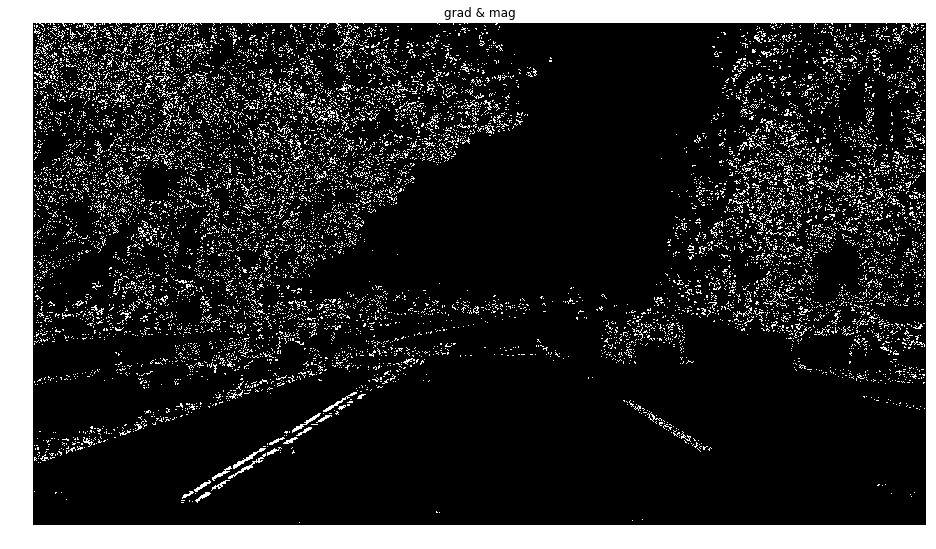

<function __main__.update>

In [284]:
def abs_sobel_x_y_mag_dir(channel, sobel_kernel=3,
           abs_sobel_x_thresh_min=30, abs_sobel_x_thresh_max=150,
           abs_sobel_y_thresh_min=30, abs_sobel_y_thresh_max=150,
           mag_thresh_min=20, mag_thresh_max=255,
           dir_threshold_min=0.6, dir_threshold_max=1.3):
    # Choose a Sobel kernel size
    ksize = sobel_kernel # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(channel, orient='x', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_x_thresh_min, abs_sobel_thresh_max=abs_sobel_x_thresh_max)
    grady = abs_sobel_thresh(channel, orient='y', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_y_thresh_min, abs_sobel_thresh_max=abs_sobel_y_thresh_max)
    mag_binary = mag_thresh(channel, sobel_kernel=ksize, mag_thresh_min=mag_thresh_min, mag_thresh_max=mag_thresh_max)
    dir_binary = dir_threshold(channel, sobel_kernel=ksize, dir_thresh_min=dir_threshold_min, dir_thresh_max=dir_threshold_max)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined
    
def update(sobel_kernel=3, 
           abs_sobel_x_thresh_min=30, abs_sobel_x_thresh_max=100,
           abs_sobel_y_thresh_min=30, abs_sobel_y_thresh_max=100,
           mag_thresh_min=30, mag_thresh_max=100,
           dir_threshold_min=0.9, dir_threshold_max=1.3):
    # Choose a Sobel kernel size
    ksize = sobel_kernel # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(channel, orient='x', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_x_thresh_min, abs_sobel_thresh_max=abs_sobel_x_thresh_max)
    grady = abs_sobel_thresh(channel, orient='y', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_y_thresh_min, abs_sobel_thresh_max=abs_sobel_y_thresh_max)
    mag_binary = mag_thresh(channel, sobel_kernel=ksize, mag_thresh_min=mag_thresh_min, mag_thresh_max=mag_thresh_max)
    dir_binary = dir_threshold(channel, sobel_kernel=ksize, dir_thresh_min=dir_threshold_min, dir_thresh_max=dir_threshold_max)

    combined_1 = np.zeros_like(dir_binary)

    combined_1[((gradx == 1) & (grady == 1))] = 1
    
    combined_2 = np.zeros_like(dir_binary)
    combined_2[((mag_binary == 1) & (dir_binary == 1))] = 1

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    plt.figure(figsize=(16, 12))
    plt.subplot(131)
    plt.imshow(gradx, cmap='gray')
    plt.title('gradx')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(grady, cmap='gray')
    plt.title('grady')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(mag_binary, cmap='gray')
    plt.title('mag')
    plt.axis('off')

    plt.figure(figsize=(16, 12))
    plt.subplot(121)
    plt.imshow(combined_1, cmap='gray')
    plt.title('gradx & grady')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(combined_2, cmap='gray')
    plt.title('dir')
    plt.axis('off')
    plt.show()    

    plt.figure(figsize=(16, 12))
    plt.imshow(combined, cmap='gray')
    plt.title('grad & mag')
    plt.axis('off')
    plt.show()    
    

interact(update, sobel_kernel=(3, 19),abs_sobel_x_thresh_min=(0, 255), abs_sobel_x_thresh_max=(0, 255),
                 abs_sobel_y_thresh_min=(0, 255), abs_sobel_y_thresh_max=(0, 255),
                 mag_thresh_min=(0,255), mag_thresh_max=(0,255),
                 dir_threshold_min=(0, np.pi/2), dir_threshold_max=(0, np.pi/2))

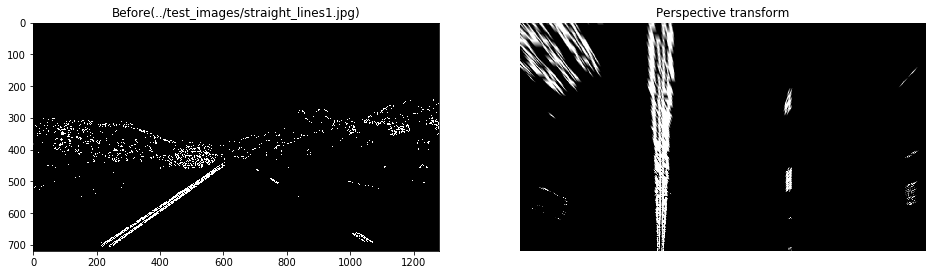

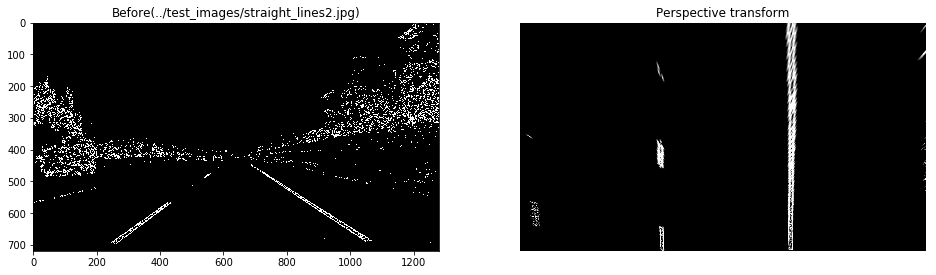

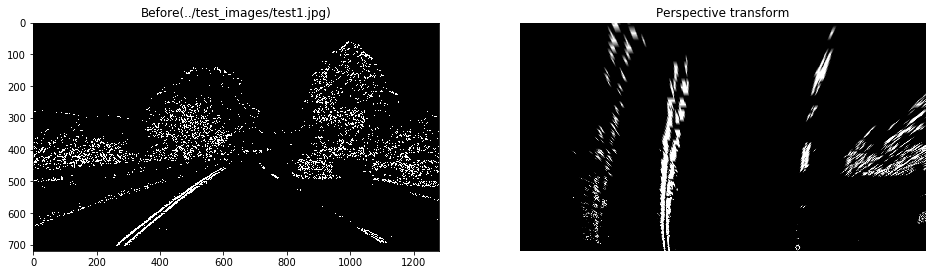

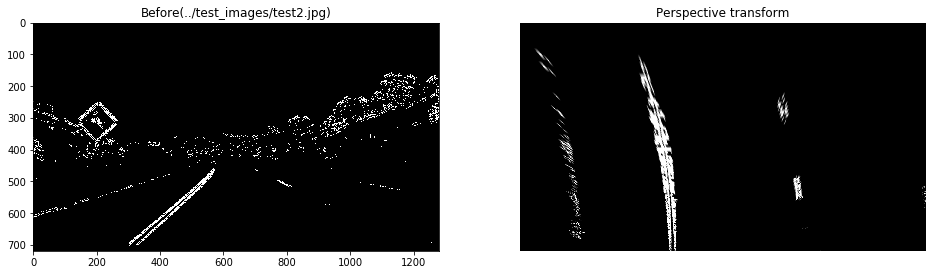

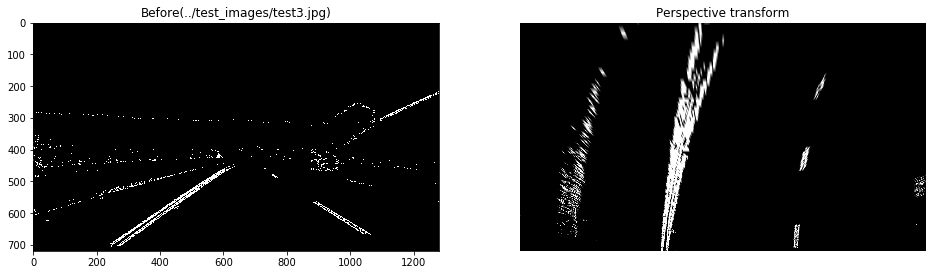

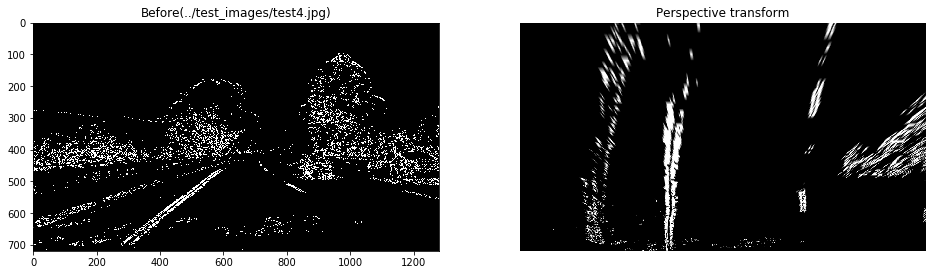

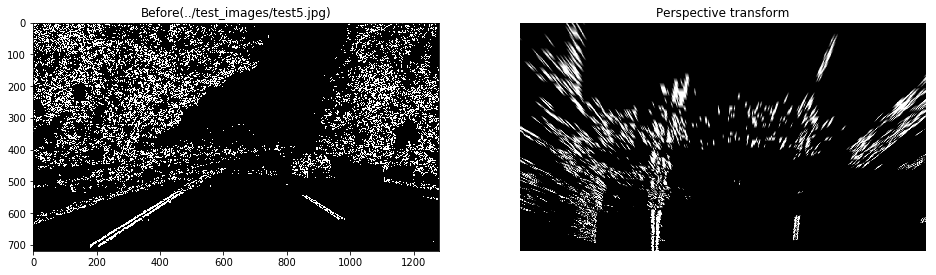

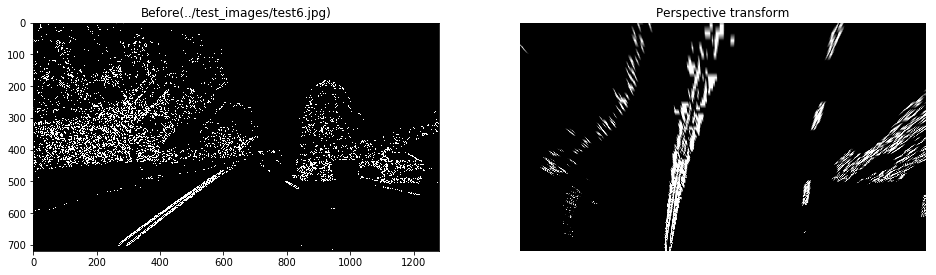

In [276]:
# mid = 1280/2
# t1, b1 = 450, 700
# t_tw = 90
# t_bw = 820
# t2, b2 = 10, 720
# tw = 400

# src = np.float32([[mid-t_tw, t1], [mid+t_tw, t1], [mid-t_bw, b1], [mid+t_bw, b1]])
# dst = np.float32([[mid-tw, t2], [mid+tw, t2], [mid-tw, b2], [mid+tw, b2]])

M = cv2.getPerspectiveTransform(src, dst)

images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)[:, :, 2]
    
    filtered = abs_sobel_x_y_mag_dir(gray)

    warped = cv2.warpPerspective(filtered, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    plt.figure(figsize=(16, 12))
    plt.subplot(121)
    plt.imshow(filtered, cmap='gray')
    
#     plt.plot(640, 420, 'o', mew=1)
    
#     plt.plot(mid-t_tw, t1, '^', mew=2)
#     plt.plot(mid+t_tw, t1, 'v', mew=2)
#     plt.plot(mid-t_bw, b1, 'x', mew=2)
#     plt.plot(mid+t_bw, b1, 's', mew=2)

#     plt.plot(mid-tw, t2, '^', mew=4)
#     plt.plot(mid+tw, t2, 'v', mew=4)
#     plt.plot(mid-tw, b2, 'x', mew=4)
#     plt.plot(mid+tw, b2, 's', mew=4)
    
    plt.title('Before('+fname+')')
    plt.subplot(122)
    plt.imshow(warped, cmap='gray')
    plt.title('Perspective transform')
    plt.axis('off')
    plt.show()